# Dynamic Programming

We will be using dynamic programming on sample 4x4 grid world and study **Policy Iteration** 

![GridWorld](./images/gridworld.png "Grid World")


### Policy Iteration (Improvement)

Policy improvement is carried out by repeatedly applying policy evaluation and greedy action selection steps in a cycle till there is no further change. Pseudo code for the algorithm is given in Fig 3-4

#### Running in Colab/Kaggle

If you are running this on Colab, please uncomment below cell and run this to install required dependencies.

In [ ]:
## Uncomment and execute this cell to install all the the dependencies if running in Google Colab or Kaggle

## Uncomment and run for Colab
# !git clone https://github.com/nsanghi/drl-2ed
# %cd /content/drl-2ed 
# %cd chapter3


## Uncomment and run for Kaggle
# !git clone https://github.com/nsanghi/drl-2ed
# %cd /content/drl-2ed 
# %cd chapter3

In [7]:
# Initial imports and environment setup
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

# create grid world environment
from gridworld import GridworldEnv
env = GridworldEnv()

In [8]:
# Custom print to show state values inside the grid
def grid_print(V, k=None):
    ax = sns.heatmap(V.reshape(env.shape),
                     annot=True, square=True,
                     cbar=False, cmap='Blues',
                     xticklabels=False, yticklabels=False)

    if k:
        ax.set(title="State values after K = {0}".format(k))
    else:
        ax.set(title="State Values".format(k))
    plt.show()

In [9]:
# Policy Evaluation

def policy_evaluation(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and
    a full description of the environment's dynamics.

    Args:
        policy:[S, A] shaped matrix representing the policy. Random in our case
        env: env.P -> transition dynamics of the environment.
            env.P[s][a] [(prob, next_state, reward, done)].
            env.nS is number of states in the environment.
            env.nA is number of actions in the environment.
        theta: Stop evaluation once value function change is
            less than theta for all states.
        discount_factor: Gamma discount factor.

    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a (all 0) value function
    V = np.zeros(env.nS)
    V_new = np.copy(V)
    while True:
        delta = 0
        # For each state, perform a "backup"
        for s in range(env.nS):
            v = 0
            # Look at the possible next actions
            for a, pi_a in enumerate(policy[s]):
                # For each action, look at the possible next states...
                for prob, next_state, reward, done in env.P[s][a]:
                    # Calculate the expected value as per backup diagram
                    v += pi_a * prob * \
                        (reward + discount_factor * V[next_state])
            # How much our value function changed (across any states)
            V_new[s] = v
            delta = max(delta, np.abs(V_new[s] - V[s]))
        V = np.copy(V_new)
        # Stop if change is below a threshold
        if delta < theta:
            break
    return np.array(V)

In [10]:
# Policy Improvement

def policy_improvement(policy, V, env, discount_factor=1.0):
    """
    Improve a policy given an environment and a full description
    of the environment's dynamics and the state-values V.

    Args:
        policy: [S, A] shaped matrix representing the policy.
        V: current state-value for the given policy
        env: env.P -> transition dynamics of the environment.
            env.P[s][a] [(prob, next_state, reward, done)].
            env.nS is number of states in the environment.
            env.nA is number of actions in the environment.
        discount_factor: Gamma discount factor.

    Returns:
        policy: [S, A] shaped matrix representing improved policy.
        policy_changed: boolean which has value of `True` if there
                        was a change in policy
    """

    def argmax_a(arr):
        """
        Return idxs of all max values in an array.
        """
        max_idx = []
        max_val = float('-inf')
        for idx, elem in enumerate(arr):
            if elem == max_val:
                max_idx.append(idx)
            elif elem > max_val:
                max_idx = [idx]
                max_val = elem
        return max_idx

    policy_changed = False
    Q = np.zeros([env.nS, env.nA])
    new_policy = np.zeros([env.nS, env.nA])

    # For each state, perform a "greedy improvement"
    for s in range(env.nS):
        old_action = np.array(policy[s])
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[s][a]:
                # Calculate the expected value as per backup diagram
                Q[s, a] += prob * (reward + discount_factor * V[next_state])

        # get maximizing actions and set new policy for state s
        best_actions = argmax_a(Q[s])
        new_policy[s, best_actions] = 1.0 / len(best_actions)

    if not np.allclose(new_policy[s], policy[s]):
        policy_changed = True

    return new_policy, policy_changed

In [11]:
# Policy Iteration

def policy_iteration(env, discount_factor=1.0, theta=0.00001):

    # initialize a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    while True:
        V = policy_evaluation(policy, env, discount_factor, theta)
        policy, changed = policy_improvement(policy, V, env, discount_factor)
        if not changed:  # terminate iteration once no improvement is observed
            V_optimal = policy_evaluation(policy, env, discount_factor, theta)
            print("Optimal Policy\n", policy)
            return np.array(V_optimal)

Optimal Policy
 [[0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.5  0.5 ]
 [1.   0.   0.   0.  ]
 [0.5  0.   0.   0.5 ]
 [0.   0.   0.5  0.5 ]
 [0.   0.   1.   0.  ]
 [1.   0.   0.   0.  ]
 [0.5  0.5  0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   0.  ]
 [1.   0.   0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]]


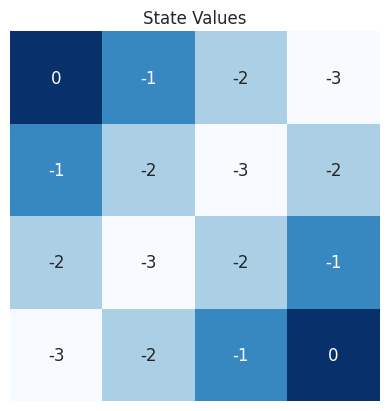

In [12]:
# Run policy iteration on Grid world
V_star = policy_iteration(env)

# Print optimal policy state values
grid_print(V_star.reshape(env.shape))

### Conclusion

We see that optimal state values are negative of number of steps required to reach the closest terminal state. As the reward is -1 for each time step till agent reaches terminal state, the optimal policy would take the agent to terminal state in minimal number of possible steps. For some states, more than one action could lead to same number of steps to reach terminal state. For example, look at top right state with value -3, it takes 3 steps to reach the terminal state at top-left or terminal state at bottom-right. In other words, the state values is negative of Manhattan distance between the state and nearest terminal state.